In [117]:
import numpy as np
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import math
import random
from scipy import stats

import geopandas as gpd
import pandas as pd

import itertools
from collections import Counter

from ast import literal_eval

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm

from scipy.stats import zscore

import folium
import branca.colormap as cmp
import json

from gensim import corpora

from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

---

In [8]:
## code from https://github.com/qiangsiwei/shanghai_geographical_topics

# list of documents -> docs
# for doc in docs: doc[0] -> locality + doc[1] -> content as a list of words

In [9]:
class LDALocalGlobalSampler(object):
    def __init__(self, docs=None, conts=None, num_topics=None, alpha=0.5, beta=0.5, gama=0.2, lamd=1.0):
        self.a, self.b, self.c, self.d, self.T = float(alpha), float(beta), float(gama), float(lamd), int(num_topics)
        self.docs, self.conts = docs, conts
        self.locs = list(set(doc[0] for doc in self.docs))
        self.vocab = list(set(word for doc in self.docs for word in doc[1]))
        self.L, self.W = len(self.locs), len(self.vocab)
        self.to_id = {loc: i for (i, loc) in enumerate(self.locs)}
        self.to_int = {word: w for (w, word) in enumerate(self.vocab)}
        self.nt = [0] * self.T
        self.ndc = [[0] * 2 for _ in self.docs]
        self.ng, self.nl = 0, [0 for _ in self.locs]
        self.ngt, self.nlt = [0] * self.T, [[0] * self.T for _ in self.locs]
        self.nwt = [[0] * self.T for _ in self.vocab]
        self.assignments = []
        for _d, (_loc, _doc) in enumerate(self.docs):
            for _i, _word in enumerate(_doc):
                _l = self.to_id[_loc]
                _w = self.to_int[_word]
                _c = int(random.randint(0, max(1,self.d)) >= 1)
                _t = random.randint(0, self.T-1)
                _z = [_d, _l, _w, _c, _t]
                self.assignments.append(_z)
        for _z in self.assignments:
            _d, _l, _w, _c, _t = _z
            self.ndc[_d][_c] += 1
            if _c:
                self.nl[_l] += 1
                self.nlt[_l][_t] += 1
            else:
                self.ng += 1
                self.ngt[_t] += 1
            self.nt[_t] += 1
            self.nwt[_w][_t] += 1

    def next(self):
        return math.exp(-sum([self.sample(z) for z in self.assignments])/sum(self.nt))

    def sample(self, z):
        _d, _l, _w, _c_old, _t_old = z
        # restore
        self.ndc[_d][_c_old] -= 1
        if _c_old:
            self.nl[_l] -= 1
            self.nlt[_l][_t_old] -= 1
        else:
            self.ng -= 1
            self.ngt[_t_old] -= 1
        self.nt[_t_old] -= 1
        self.nwt[_w][_t_old] -= 1
        # sample
        unnorm_ps = [(0, t, self.h1(_w,t)*self.f(_d,0)) for t in range(self.T)] + \
                    [(1, t, self.h2(_l,_w,t)*self.f(_d,1)*self.d) for t in range(self.T)]
        r = random.random() * sum([_p[2] for _p in unnorm_ps])
        _c_new, _t_new = 1, self.T-1
        for i in range(2*self.T):
            r = r - unnorm_ps[i][2]
            if r < 0:
                _c_new, _t_new, _ = unnorm_ps[i]
                break
        # compute log properbility
        _properbility = math.log(self.h2(_l,_w,_t_new) if _c_new else self.h1(_w,_t_new))
        # update
        z[3], z[4] = _c_new, _t_new
        self.ndc[_d][_c_new] += 1
        if _c_new:
            self.nl[_l] += 1
            self.nlt[_l][_t_new] += 1
        else:
            self.ng += 1
            self.ngt[_t_new] += 1
        self.nt[_t_new] += 1
        self.nwt[_w][_t_new] += 1
        return _properbility

    def f(self, d, c): # sample for locality
        return self.ndc[d][c] + self.c

    def h1(self, w, t): # sample for global topic
        return (self.ngt[t] + self.a) / (self.ng + self.a * self.T) * \
               (self.nwt[w][t] + self.b) / (self.nt[t] + self.b * self.W)

    def h2(self, l, w, t): # sample for local topic
        return (self.nlt[l][t] + self.a) / (self.nl[l] + self.a * self.T) * \
               (self.nwt[w][t] + self.b) / (self.nt[t] + self.b * self.W)

    def pw_z(self, w, t):
        return (self.nwt[w][t] + self.b) / (self.nt[t] + self.b * self.W)

    def estimate_phi(self):
        return [[self.pw_z(w, t) for w in range(self.W)] for t in range(self.T)]

    def pz_d(self, l, t):
        return (self.nlt[l][t] + self.a) / (self.nl[l] + self.a * self.T)

    def estimate_theta(self):
        return [[self.pz_d(l, t) for t in range(self.T)] for l in range(self.L)]

    def topic_weight(self, t):
        return self.nt[t]
        
    def topic_keys(self, return_prob=False, num_displayed=10):
        phi, tks = self.estimate_phi(), []
        for w_ps in phi:
            if return_prob:
                tks.append([p for p in w_ps])
            else:
                tuples = [(p, self.vocab[i]) for i, p in enumerate(w_ps)]
                tuples.sort(reverse=True)
                tks.append([word for (p, word) in tuples[:num_displayed]])
        return tks

    def local_topics(self):
        theta, dks = self.estimate_theta(), []
        for t_ps in theta:
            tuples = [(p, t) for t, p in enumerate(t_ps)]
            tuples.sort(reverse=True)
            dks.append(tuples)
        return dks

    def global_topics(self):
        tuples = [(p, t) for t, p in enumerate([
            (self.ngt[t] + self.a) / (sum(self.ngt) + self.a * self.T)
                for t in range(self.T)])]
        tuples.sort(reverse=True)
        return tuples

    def doc_locality(self, ratio, locations=[]):
        _dict = {}
        for z in self.assignments:
            _d, _l, _w, _c, _t = z
            _dict[_d] = _dict.get(_d,{'len':0,'glob':0,'local':0})
            _dict[_d]['len'] += 1
            _dict[_d]['glob'] += self.h1(_w,_t)
            _dict[_d]['local'] += self.h2(_l,_w,_t)
        _tuples = [(_v['local']/_v['len'],[_v['local']/_v['glob'], _d]) for _d, _v in _dict.items()]
        _tuples.sort(reverse=True)
        for _index in xrange(int(len(_tuples)*ratio), int(len(_tuples)*ratio)+10**4):
            if self.conts[_tuples[_index][1][1]][0] in locations:
                print(_tuples[_index], '\t'.join(self.conts[_tuples[_index][1][1]]))

In [11]:
def run_tfidf(num_clusters=20, num_displayed=10, print_results=False):
    _index, _docs, _freqs, _dicts = 0, [], {}, {}
    for _name, _list in _location_dict.items():
        if len(_list) >= LOCATION_THRES:
            _list = [_entry['_words'] for _entry in sorted(_list, 
                        key=lambda _en:_en['_len'], reverse=True)[:REVIEW_LIMIT]]
            for _doc in _list:
                _docs.append(' '.join(_doc))
                _freqs[_name] = _freqs.get(_name,{})
                _dicts[_name] = _dicts.get(_name,[]) + [_index]
                for _word in _doc:
                    #_word = _word.decode('utf-8')
                    _freqs[_name][_word] = _freqs[_name].get(_word,0)+1
                _index += 1
    if print_results: print(len(_dicts))
    transformer, vectorizer = TfidfTransformer(), CountVectorizer()
    tfidf = transformer.fit_transform(vectorizer.fit_transform(_docs))
    _words, _weights = vectorizer.get_feature_names(), tfidf.toarray()
    if print_results: print('word vector length:', len(_weights))
    word_vector = []
    for _i, (_name, _list) in enumerate(_dicts.items()):
        _weight = np.array([_weights[_ele] for _ele in _list]).sum(axis=0)
        word_vector.append(_weight)
        _keywords = [u'{},{}'.format(_item['_word'],_freqs[_name].get(_item['_word'],0))
                        for _item in sorted([{'_word':_word,'_value':_value} 
                                                for (_word,_value) in zip(_words,_weight)], 
                                            key=lambda _entry:_entry['_value'], reverse=True)]
        # show location keywords
        if print_results: print(_i, _name, '\t'.join(_keywords[:num_displayed]))
    from sklearn.cluster import KMeans
    est = KMeans(n_clusters=num_clusters)
    est.fit(word_vector)
    for _cluster_center in est.cluster_centers_:
        _tuples = [(_value, _word) for _word, _value in enumerate(_cluster_center)]
        _tuples.sort(reverse=True)
        # show cluster keywords
        if print_results: print('\t'.join([_words[_word] for (_value, _word) in _tuples[:num_displayed]]))

In [12]:
def run_lda(model, num_iteration=101, save_step=20, num_topics=20, local_radio=0.6):
    _index, _docs, _conts = 0, [], []
    for _name, _list in _location_dict.items():
        if len(_list) >= LOCATION_THRES:
            _list = [(_entry['_words'],_entry['_cont']) for _entry in 
                        sorted(_list, key=lambda _en:_en['_len'], reverse=True)[:REVIEW_LIMIT]]
            # print _index, _name, len(_list)
            _docs.extend([(_name,_doc[0]) for _doc in _list])
            _conts.extend([(_name,_doc[1]) for _doc in _list])
            _index += 1
    if model == 'LDASampler':
        lda = LDASampler(docs=_docs, num_topics=num_topics, alpha=0.5, beta=0.5)
    if model == 'LDALocalSampler':
        lda = LDALocalSampler(docs=_docs, num_topics=num_topics, alpha=0.5, beta=0.5)
    if model == 'LDALocalGlobalSampler':
        lda = LDALocalGlobalSampler(docs=_docs, conts=_conts, num_topics=num_topics, alpha=0.5, beta=0.5, gama=0.5, lamd=local_radio)
    for _index in range(num_iteration):
        print("iteration:", _index)
        perplexity = lda.next()
        if _index % save_step == 0:
            path_file = 'lgda_results/iteration_{}.txt'.format(str(_index).zfill(3))
            with open(path_file,'w') as _file:
                print("perplexity:", perplexity)
                # save word topic probabilities
                _file.write('word topic probabilities:\n')
                tks = lda.topic_keys()
                for i, tk in enumerate(tks):
                    _file.write('{}\t{}\t{}\n'.format(i, lda.topic_weight(i), '\t'.join(tk)))
                # save local topic probabilities
                _file.write('local topic probabilities:\n')
                dks, entropy = lda.local_topics(), {'topic':0,'probs':{}}
                for l, dk in enumerate(dks):
                    _file.write('{}\n{}\n'.format(lda.locs[l], '\t'.join(['{}:{:.3}'.format(t, p) for (p, t) in dk])))
                    entropy['topic'] += -sum([p*math.log(p) for (p, t) in dk])
                    for (p, t) in dk:
                         entropy['probs'][t] = entropy['probs'].get(t,[])+[p]
                tks, KL = lda.topic_keys(return_prob=True), 0
                for _i, _prob1 in enumerate(tks):
                    for _j, _prob2 in enumerate(tks):
                        if _i != _j:
                            KL += -sum([_p1*math.log(_prob2[_k]/_p1) for _k, _p1 in enumerate(_prob1)])
                print("topic entropy:", entropy['topic']/len(dks))
                print("location entropy:", sum([sum([-p*math.log(p) for p in ps]) for t, ps in entropy['probs'].items()])/len(entropy['probs']))
                print("topic KL-divergence:", KL/(len(tks)*(len(tks)-1)))
                # save global topic probabilities
                # if model == 'LDALocalGlobalSampler':
                #     _file.write('global topic probabilities:\n')
                #     _file.write('{}\n'.format('\t'.join(['{}:{:.3}'.format(t, p) for (p, t) in lda.global_topics()])))
                #     lda.doc_locality(ratio=0, locations=["外滩"])


In [13]:
def run_lda_assess(model
                  , num_iteration=101
                  , save_step=20
                  , num_topics=20
                  , local_radio=0.6
                  , alpha=0.5
                  , beta=0.5
                  , gamma=0.5
                  , r_seed = 0
                  , print_steps = False
                  , write_results = False
                  , corpus = None
                  ,dictionary = None
                 ):
    
    _index, _docs, _conts = 0, [], []
    for _name, _list in _location_dict.items():
        if len(_list) >= LOCATION_THRES:
            _list = [(_entry['_words'],_entry['_cont']) for _entry in 
                        sorted(_list, key=lambda _en:_en['_len'], reverse=True)[:REVIEW_LIMIT]]
            # print _index, _name, len(_list)
            _docs.extend([(_name,_doc[0]) for _doc in _list])
            _conts.extend([(_name,_doc[1]) for _doc in _list])
            _index += 1
    if model == 'LDASampler':
        lda = LDASampler(docs=_docs, num_topics=num_topics, alpha=0.5, beta=0.5)
    if model == 'LDALocalSampler':
        lda = LDALocalSampler(docs=_docs, num_topics=num_topics, alpha=0.5, beta=0.5)
    if model == 'LDALocalGlobalSampler':
        random.seed(r_seed)
        lda = LDALocalGlobalSampler(docs=_docs
                                    , conts=_conts
                                    , num_topics=num_topics
                                    , alpha=alpha
                                    , beta=beta
                                    , gama=gamma
                                    , lamd=local_radio#0.6 ###### TODO #######
                                   )
    
    # define scores lists
    perplexities = []
    topic_entropies = []
    location_entropies = []
    topic_KL_divs = []
    coherences = []
    
    for _index in range(num_iteration):
        if print_steps: 
            print("iteration:", _index)
        
        # scores
        perplexity = lda.next()
        tks = lda.topic_keys()
        dks, entropy = lda.local_topics(), {'topic':0,'probs':{}}
        for l, dk in enumerate(dks):
            entropy['topic'] += -sum([p*math.log(p) for (p, t) in dk])
            for (p, t) in dk:
                entropy['probs'][t] = entropy['probs'].get(t,[])+[p]
        tks, KL = lda.topic_keys(return_prob=True), 0
        for _i, _prob1 in enumerate(tks):
            for _j, _prob2 in enumerate(tks):
                if _i != _j:
                    KL += -sum([_p1*math.log(_prob2[_k]/_p1) for _k, _p1 in enumerate(_prob1)])
                    
        topic_entropy = entropy['topic']/len(dks)
        location_entropy = sum([sum([-p*math.log(p) for p in ps]) for t, ps in entropy['probs'].items()])/len(entropy['probs'])
        topic_KL_div = KL/(len(tks)*(len(tks)-1))
        
        # coherence test with gensim
        tks=lda.topic_keys(num_displayed=10)
        cm = CoherenceModel(topics=tks, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence = cm.get_coherence()  # get coherence value
        
        perplexities.append(perplexity)
        topic_entropies.append(topic_entropy)
        location_entropies.append(location_entropy)
        topic_KL_divs.append(topic_KL_div)
        coherences.append(coherence)
        
        if (_index % save_step == 0 and write_results or _index == num_iteration-1):
            path_file = 'lgda_results/iteration_{}.txt'.format(str(_index).zfill(3))
            with open(path_file,'w', encoding='utf-8') as _file:
                print("perplexity:", perplexity)
                # save word topic probabilities
                _file.write('word topic probabilities:\n')
                tks = lda.topic_keys()
                for i, tk in enumerate(tks):
                    _file.write('{}\t{}\t{}\n'.format(i, lda.topic_weight(i), '\t'.join(tk)))
                # save local topic probabilities
                _file.write('local topic probabilities:\n')
                dks, entropy = lda.local_topics(), {'topic':0,'probs':{}}
                for l, dk in enumerate(dks):
                    _file.write('{}\n{}\n'.format(lda.locs[l], '\t'.join(['{}:{:.3}'.format(t, p) for (p, t) in dk])))
                    entropy['topic'] += -sum([p*math.log(p) for (p, t) in dk])
                    for (p, t) in dk:
                         entropy['probs'][t] = entropy['probs'].get(t,[])+[p]
                tks, KL = lda.topic_keys(return_prob=True), 0
                for _i, _prob1 in enumerate(tks):
                    for _j, _prob2 in enumerate(tks):
                        if _i != _j:
                            KL += -sum([_p1*math.log(_prob2[_k]/_p1) for _k, _p1 in enumerate(_prob1)])
                if print_steps: 
                    print("topic entropy:", entropy['topic']/len(dks))
                    print("location entropy:", sum([sum([-p*math.log(p) for p in ps]) for t, ps in entropy['probs'].items()])/len(entropy['probs']))
                    print("topic KL-divergence:", KL/(len(tks)*(len(tks)-1)))
                    print("coherence:", coherence)
              
    return lda, perplexities, topic_entropies, location_entropies, topic_KL_divs, coherences



-----

---

In [14]:
# GLOBAL PARAMETERS 
# MIGHT NEED SOME TUNING AS WELL

FREQ_THRES = 30 # appear in less than n total document
FREQ_HIGH_THRES = 0.9   # appear in more than % total document

LOCATION_THRES, REVIEW_LIMIT = 100, 50

## Loading Twitter Data

### Import

In [15]:
def try_literal_eval(s):
    """ load python object as they are intended to be """
    try:
        return literal_eval(s)
    except ValueError:
        return s

In [16]:
%%time

_df = pd.read_csv("./preprocessed_data/nlp_geo_tweets_stopwords_cleaned.csv")
for col in ["hashtags", "tokens", "tokens_cleand", "w_pos_lemma"]:
    _df[col] = _df[col].apply(literal_eval)

_df.shape

Wall time: 41.6 s


In [17]:
LOCATIONS_ID = list(set(_df.dep_code.values))

geo_departements = "./geodata/departements.geojson"
gdf_departements = gpd.read_file(geo_departements)

_id2name = pd.Series(gdf_departements.nom.values,index=gdf_departements.code).to_dict()

### Select

In [18]:
# select only regions with more tweets than average ---> can be changed
dep_count = _df.groupby("dep_code").count()[["created_at"]]
dep_count.rename(columns={"created_at":"tweet_count"}, inplace=True)
dep_count.sort_values(by="tweet_count", ascending=False)
dep_count_filtered = dep_count[dep_count.tweet_count > dep_count.tweet_count.mean()] # can be changed
selected_dep = dep_count_filtered.index.values 
df = _df[[dep in selected_dep for dep in _df.dep_code]].copy()
df["hashtags"] = [[ht.lower() for ht in hashtags] for hashtags in df.hashtags]
df.shape

(233596, 26)

In [19]:
dep_count_geo = pd.merge(dep_count_filtered
                         , gdf_departements
                         , how='inner'
                         , right_on="code"
                         , left_on="dep_code"
                         , validate = "many_to_one"
                        ).reset_index(drop=True)
dep_count_geo["code"].astype(str)
dep_count_geo.shape


(23, 4)

In [25]:
linear = cmp.LinearColormap(
    ["white", "blue"],
    vmin=0, vmax=45,
).to_step(18)

linear.caption="tweet_count (k)" #Caption for Color scale or Legend

code = dep_count_geo["code"].to_list()

def style_function(feature):
    if feature["code"] in code:
        index = dep_count_geo[dep_count_geo["code"]==feature["code"]].index.values[0]
        tweet_num = dep_count_geo.at[index, "tweet_count"]
    else:
        tweet_num = None
    return {
        "fillOpacity": 0.5,
        "color": "black",
        "opacity": 0.25,
        "weight": 0.1,
        "fillColor": "#fff" if tweet_num is None else linear(tweet_num/1000),
    }

m = folium.Map(
    location=[46.71109, 1.7191036],
    tiles="cartodbpositron",
    zoom_start=6,
)

for _, r in dep_count_geo.iterrows():
    #without simplifying the representation of each borough, the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_ = json.loads(sim_geo.to_json())
    geo_["features"][0]["code"] = r["code"]
    geo_j = folium.GeoJson(data=geo_,
                           style_function=style_function)
    folium.Popup(f"{r['nom']}: {r['tweet_count']}").add_to(geo_j)
    geo_j.add_to(m)
linear.add_to(m)
m

## Build Corpus

In [26]:
# choose the content to analyze
lglda_material = "hashtags"

In [27]:
# build docs in format doc: [dep_code, list of tweet content material]
df_material = df[[len(mat)>0 for mat in df[lglda_material]]]
docs = [list(loc_tweet) for loc_tweet in zip(df.dep_code.values, df_material[lglda_material].values)]

# build dict
if FREQ_HIGH_THRES <= 1:
    # high_thres = FREQ_HIGH_THRES*len(df_material)
    high_thres = FREQ_HIGH_THRES
else:
    high_thres = FREQ_HIGH_THRES/len(df_material)
if FREQ_THRES < 1:
    low_thres = FREQ_THRES*len(df_material)
else:
    low_thres = FREQ_THRES

# all_material = list(itertools.chain(*df_material[lglda_material].values))
# word_freq = (Counter(all_material)).most_common()
# wordDict = [w[0] for w in word_freq if (w[1]>low_thres and w[1]<high_thres)]

# using gensim corpora to filter the words

dictionary = corpora.Dictionary(df_material['hashtags'])
dictionary.filter_extremes(no_below=FREQ_THRES, no_above=FREQ_HIGH_THRES)
corpus = [dictionary.doc2bow(tweet) for tweet in df_material['hashtags']]
wordDict = list(dictionary.token2id.keys())


_location_dict, _tweet_count, _word_count = {}, 0, 0

for _, row in tqdm(df_material.iterrows()):
    _id = row.dep_code
    _words = []
    _cont = row.text_clean # not completely sure what it is used for ?
    for _word in row[lglda_material]:
        if _word in wordDict:
            _words.append(_word)
    if len(_words) >=1:
        _tweet_count+=1
        _word_count+=len(_words)
        _location_dict[_id2name[_id]] = _location_dict.get(_id2name[_id],[]) + \
                                        [{'_words':_words,'_len':len(_words),'_cont':_cont}]

print("***  ***  ***  dataset statistics  ***  ***  ***")
print("tweet count:", _tweet_count)
print("location count:", len(_location_dict))
print("average word per tweet:", 1.*_word_count/_tweet_count)
    
    
run_tfidf()

25405it [00:02, 10385.76it/s]


***  ***  ***  dataset statistics  ***  ***  ***
tweet count: 11700
location count: 23
average word per tweet: 1.2541880341880343


In [86]:
n_it_test = 201
lda, perplexities, topic_entropies, location_entropies, topic_KL_divs, coherences = run_lda_assess('LDALocalGlobalSampler'
                                                                   , num_iteration=n_it_test
                                                                   , save_step=5
                                                                   , num_topics=11
                                                                   , local_radio=0.6
                                                                   , alpha=0.5
                                                                   , beta=0.5
                                                                   , gamma=0.5
                                                                   , r_seed = 0
                                                                   , print_steps = False
                                                                   , write_results = False
                                                                   , corpus = corpus
                                                                   , dictionary = dictionary
                                                                  )

perplexity: 14.884953456879462


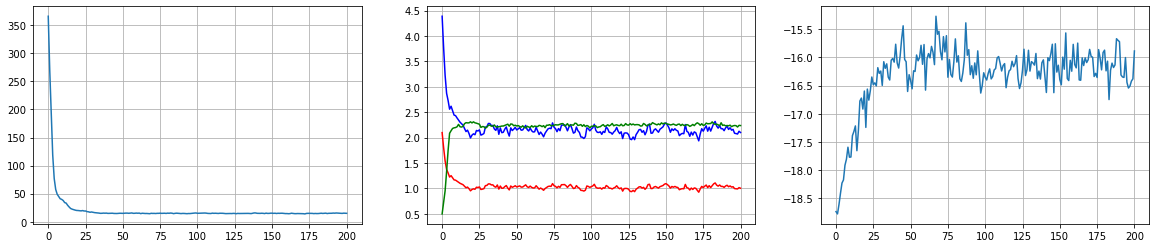

In [87]:
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot (131)
ax2 = fig.add_subplot (132)
ax3 = fig.add_subplot (133)
ax1.plot(range(n_it_test), perplexities)
ax1.grid()
# ax2.plot(range(n_it_test), topic_entropies, marker="o", c='red', linewidth=0.5, markersize=6 )
# ax2.plot(range(n_it_test), location_entropies, marker="s", c='blue', linewidth=0.5, markersize=6 )
# ax2.plot(range(n_it_test), topic_KL_divs, marker="^", c='green', linewidth=0.5, markersize=6)
ax2.plot(range(n_it_test), topic_entropies,c='red')
ax2.plot(range(n_it_test), location_entropies, c='blue')
ax2.plot(range(n_it_test), topic_KL_divs, c='green')
ax2.grid()
ax3.plot(range(n_it_test), coherences)
ax3.grid()

In [90]:
np.argmax(coherences)

67

In [92]:
n_it_test = 68
lda, perplexities, topic_entropies, location_entropies, topic_KL_divs, coherences = run_lda_assess('LDALocalGlobalSampler'
                                                                   , num_iteration=n_it_test
                                                                   , save_step=1
                                                                   , num_topics=11
                                                                   , local_radio=0.6
                                                                   , alpha=0.5
                                                                   , beta=0.5
                                                                   , gamma=0.5
                                                                   , r_seed = 0
                                                                   , print_steps = False
                                                                   , write_results = True
                                                                   , corpus = corpus
                                                                   , dictionary = dictionary
                                                                  )

perplexity: 366.2083598242002
perplexity: 269.96129086554606
perplexity: 194.38716529519652
perplexity: 118.70250019069933
perplexity: 76.80657224791489
perplexity: 57.44458222309694
perplexity: 48.88691302982042
perplexity: 44.924137036329945
perplexity: 40.84598656422711
perplexity: 39.726632100829164
perplexity: 37.77114311325788
perplexity: 34.04382262817532
perplexity: 33.08012689224956
perplexity: 29.216637947091563
perplexity: 26.18732354634422
perplexity: 23.4919618220914
perplexity: 22.296046240010256
perplexity: 21.4219231476606
perplexity: 20.617200539797594
perplexity: 19.993031808316623
perplexity: 19.85928629973065
perplexity: 19.503782015926845
perplexity: 19.21785465869298
perplexity: 19.771487866265417
perplexity: 19.02816307083731
perplexity: 19.017697293162502
perplexity: 17.936461665546865
perplexity: 17.56306577668917
perplexity: 16.742768476198503
perplexity: 17.27058884820149
perplexity: 16.706499771669876
perplexity: 16.13549271676593
perplexity: 15.909938148078

In [93]:
tks_prob = lda.topic_keys(return_prob=True)

In [94]:
tks_ = []
for wps in tks_prob:
    tuples = [(p, lda.vocab[i]) for i, p in enumerate(wps)]
    tuples.sort(reverse=True)
    data = {}
    for p, word in tuples[:10]:
        data[word] = p
    tks_.append(data)
        

In [96]:
topic_label = [f"lglda_{i+1}" for i in range(11)]

for i, topic in enumerate(tks_):
    print(f"------{topic_label[i]}-----")
    print([f"{topic[t]:.02f}: {t}" for t in topic])

------lglda_1-----
['0.25: stopdictature', '0.24: macrondestitution', '0.01: ucl', '0.01: superleagueout', '0.01: superleague', '0.01: psgfcb', '0.01: psgbay', '0.01: psg', '0.01: printemps', '0.01: paris']
------lglda_2-----
['0.16: handicap', '0.15: aah17juin', '0.14: aah', '0.04: teamom', '0.03: om', '0.03: football', '0.01: superleague', '0.01: photography', '0.01: marseille', '0.01: weekend']
------lglda_3-----
['0.08: hdpros', '0.07: art', '0.06: rouen', '0.03: teamom', '0.03: tchad', '0.03: soleil', '0.03: printemps', '0.02: spring', '0.02: regionales2021', '0.02: ramadanmubarak']
------lglda_4-----
['0.06: photooftheday', '0.06: photography', '0.06: spring', '0.06: france', '0.06: art', '0.04: strasbourg', '0.04: photo', '0.04: hautsdefrance', '0.03: lille', '0.03: printemps']
------lglda_5-----
['0.08: ucl', '0.08: psgbay', '0.08: psg', '0.07: superleague', '0.06: psgfcb', '0.06: psgbayern', '0.04: imolagp', '0.04: championsleague', '0.03: superleagueout', '0.03: f1']
------lg

In [97]:
df_lglda_short = pd.DataFrame()
df_lglda_short["topic"] = topic_label
df_lglda_short["hashtags"] = [list(topic.keys()) for topic in tks_]
df_lglda_short["hashtags"] = [", ".join(ht[:10]) for ht in df_lglda_short["hashtags"]]
df_lglda_short.to_csv("df_lglda_short.csv", index=False)

In [98]:
df_lglda_short

,topic,hashtags
0,lglda_1,"stopdictature, macrondestitution, ucl, superle..."
1,lglda_2,"handicap, aah17juin, aah, teamom, om, football..."
2,lglda_3,"hdpros, art, rouen, teamom, tchad, soleil, pri..."
3,lglda_4,"photooftheday, photography, spring, france, ar..."
4,lglda_5,"ucl, psgbay, psg, superleague, psgfcb, psgbaye..."
5,lglda_6,"paris, france, montmartre, parismaville, paris..."
6,lglda_7,"ol, monaco, olasm, cdf, paris, olpsg, ollosc, ..."
7,lglda_8,"cotedazurfrance, ilovenice, nice06, jeudiphoto..."
8,lglda_9,"chat, perdu, trouvé, chien, covid19, kohlanta,..."
9,lglda_10,"mariesaupremierregard, mariesau1erregard, mapr..."


In [99]:
tks_ = []
for wps in tks_prob:
    tuples = [(p, lda.vocab[i]) for i, p in enumerate(wps)]
    tuples.sort(reverse=True)
    data = {}
    for p, word in tuples[:15]:
        data[word] = p
    tks_.append(data)

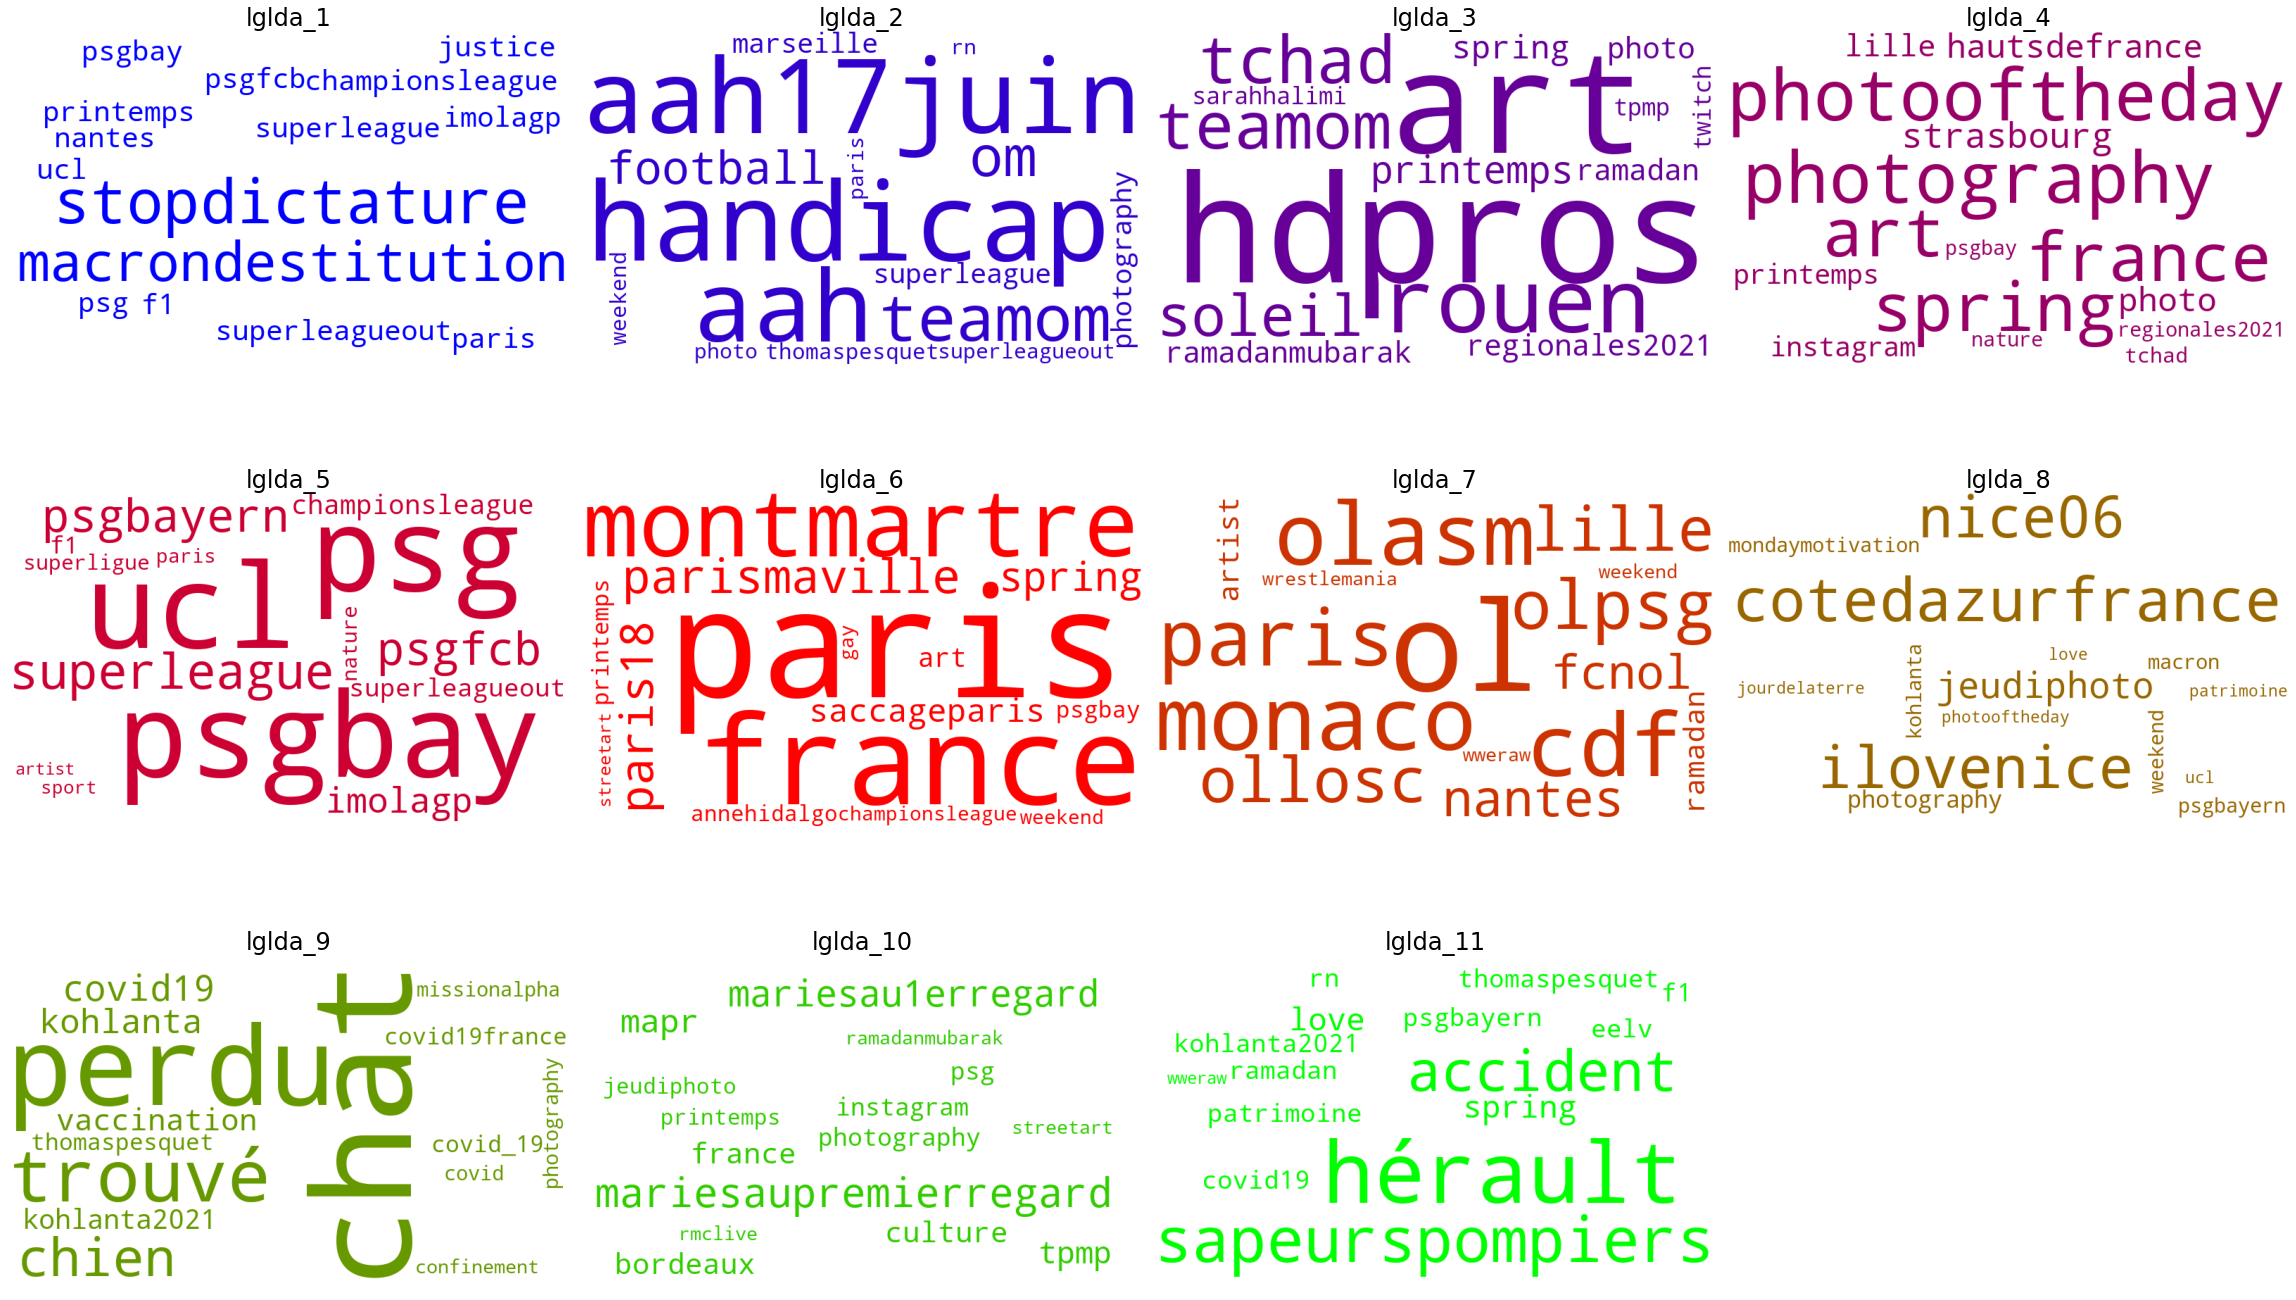

In [104]:
fig = plt.figure(figsize=((32,20)))
cmap = cm.get_cmap('brg')
k = np.linspace(0, 1, len(tks_))

for i, topic in enumerate(tks_):
    c = cmap(k[i])
    c = c[:3]
    c = tuple([int(k*255) for k in c])
    wc = WordCloud(width=800
                   , height=480
                   , color_func=lambda *args, **kwargs: c
                   , background_color='white').generate_from_frequencies(topic)
    ax = fig.add_subplot(3, 4, i+1)
    ax.set_title(f"{topic_label[i]}", fontsize=24)
    ax.imshow(wc)
    plt.axis('off')
plt.tight_layout()
plt.show
fig.savefig('topic_wordcloud_lglda.eps', bbox_inches='tight')
fig.savefig('topic_wordcloud_lglda.png', bbox_inches='tight', dpi=300)

In [111]:
dks[0]

[(0.009174311926605505, 0),
 (0.027522935779816515, 1),
 (0.009174311926605505, 2),
 (0.5779816513761468, 3),
 (0.28440366972477066, 4),
 (0.027522935779816515, 5),
 (0.009174311926605505, 6),
 (0.009174311926605505, 7),
 (0.027522935779816515, 8),
 (0.009174311926605505, 9),
 (0.009174311926605505, 10)]

In [133]:
# table
theta, dks = lda.estimate_theta(), []
for t_ps in theta:
    tuples = [(p, t) for t, p in enumerate(t_ps)]
    dks.append(tuples)

df_dep_lglda = pd.DataFrame()
df_dep_lglda["nom"] = lda.locs

for i in range(11):
     df_dep_lglda[topic_label[i]] = [t[i][0] for t in dks]
df_dep_lglda = df_dep_lglda.set_index("nom", drop=True)
df_dep_lglda.head(3)

,lglda_1,lglda_2,lglda_3,lglda_4,lglda_5,lglda_6,lglda_7,lglda_8,lglda_9,lglda_10,lglda_11
nom,,,,,,,,,,,
Nord,0.009174,0.027523,0.009174,0.577982,0.284404,0.027523,0.009174,0.009174,0.027523,0.009174,0.009174
Pyrénées-Atlantiques,0.940120,0.005988,0.005988,0.005988,0.005988,0.005988,0.005988,0.005988,0.005988,0.005988,0.005988
Hérault,0.006803,0.006803,0.006803,0.006803,0.006803,0.006803,0.006803,0.006803,0.020408,0.006803,0.918367


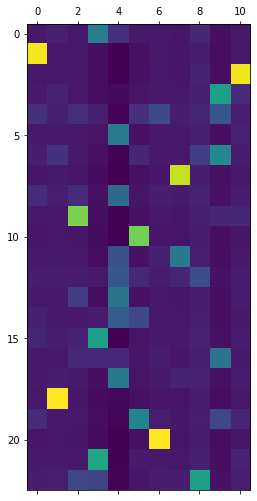

In [135]:
obs = df_dep_lglda.to_numpy()
chi2, p, dof, ex = stats.chi2_contingency(obs)
cont_mat = pd.DataFrame(columns=df_dep_lglda.columns, index=df_dep_lglda.index, dtype=float)

for i, row in enumerate(obs):
    for j, n in enumerate(row):
        cont_mat.iloc[i, j] = (n - ex[i, j])/np.sqrt(ex[i, j]) # according to https://docs.cortext.net/contingency-matrix/
plt.matshow(cont_mat)

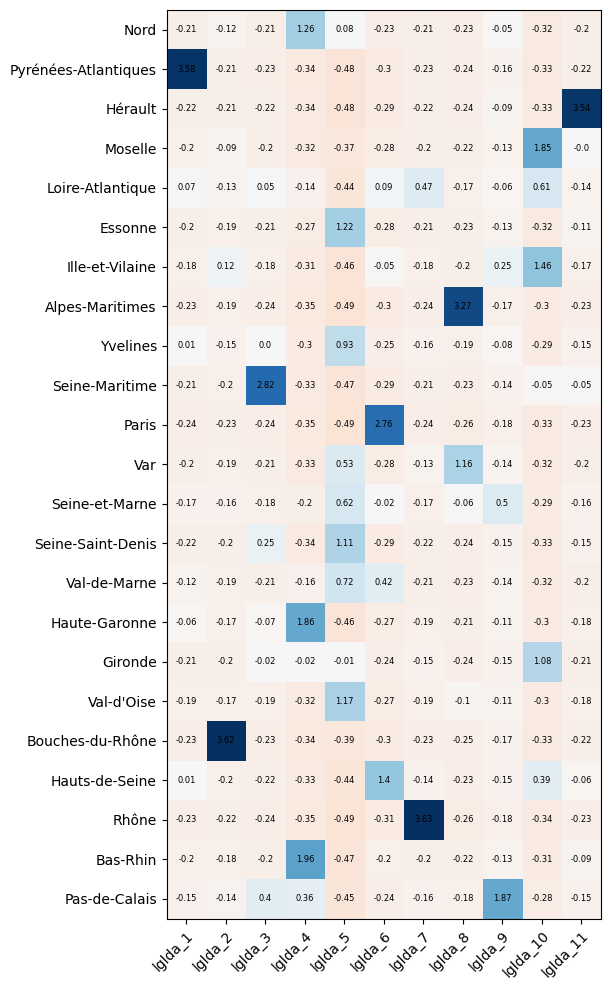

In [138]:
fig, ax = plt.subplots(1,1,figsize=(10,10), dpi=100)

departments = cont_mat.index.to_list()
hashtags = cont_mat.columns.to_list()

max_abs_value = np.max([np.abs(cont_mat.max().max()), np.abs(cont_mat.min().min())])

im = ax.imshow(cont_mat
               , cmap='RdBu'
               #, alpha=0.8
               , vmin=-max_abs_value
               , vmax=max_abs_value
              )

# We want to show all ticks...
ax.set_xticks(np.arange(len(hashtags)))
ax.set_yticks(np.arange(len(departments)))
# ... and label them with the respective list entries
ax.set_xticklabels(hashtags)
ax.set_yticklabels(departments)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(departments)):
    for j in range(len(hashtags)):
        text = ax.text(j, i, cont_mat.iloc[i, j].round(decimals=2),
                       ha="center", va="center", color="black", size=6)

fig.tight_layout()
plt.show()
fig.savefig('contingency_matrix_lglda.eps', bbox_inches='tight')

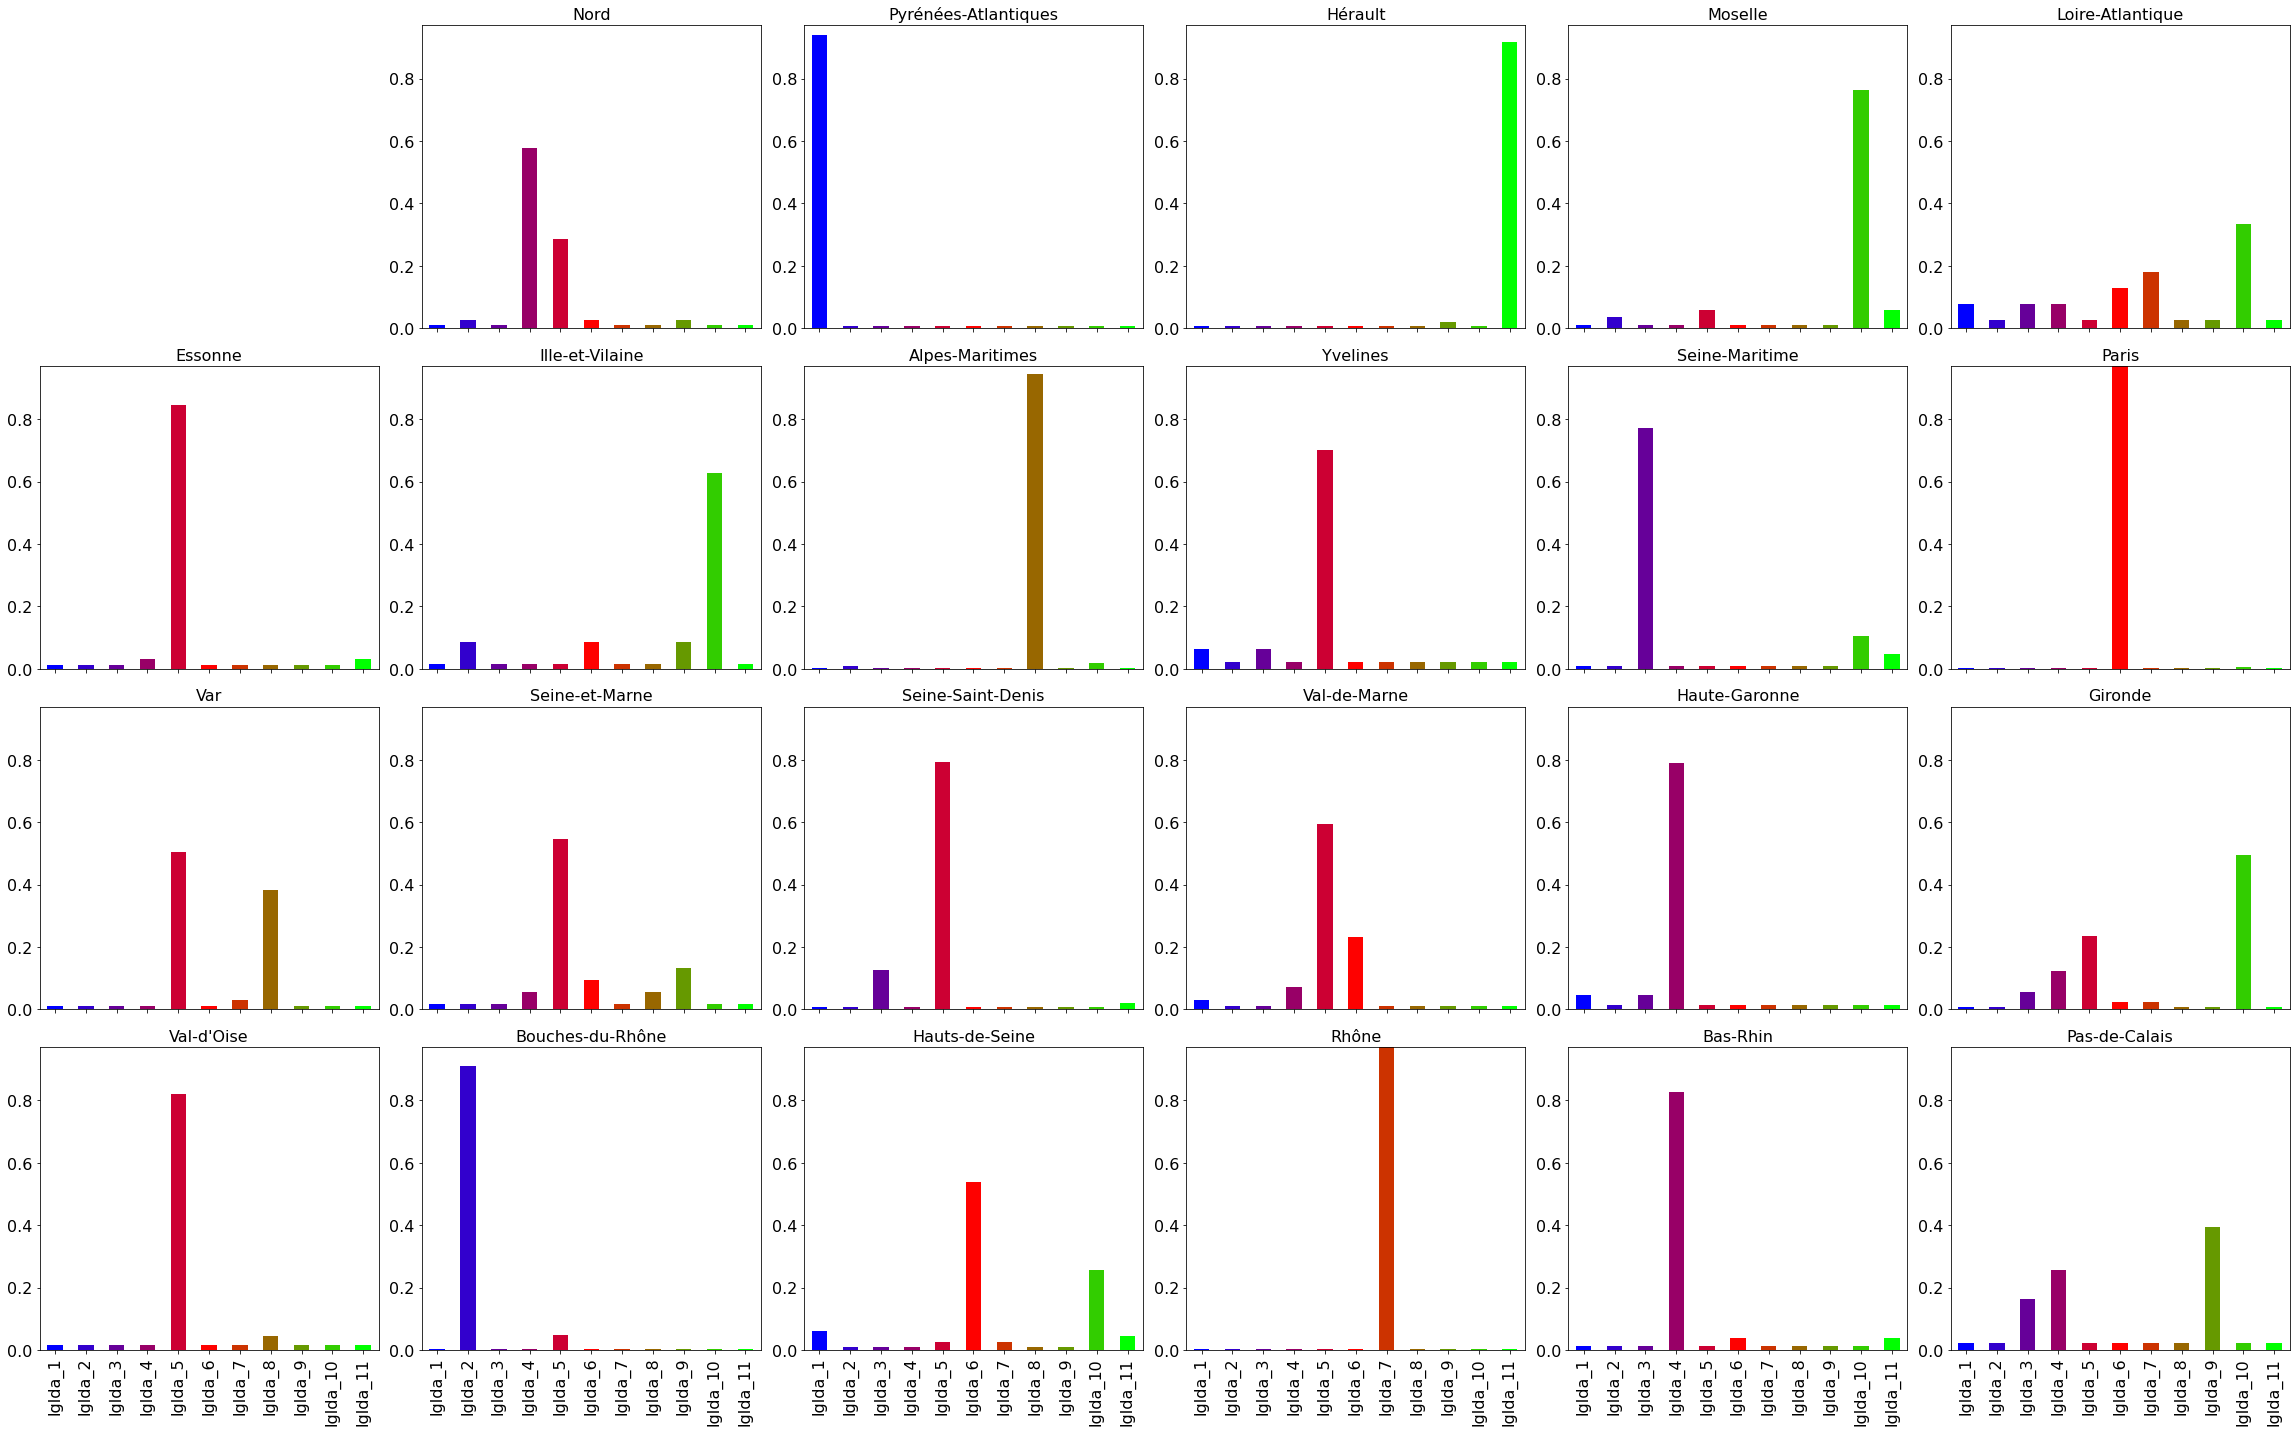

In [143]:
df_dep_lglda_norm = df_dep_lglda.div(df_dep_lglda.sum(axis=1), axis=0)
max_y = df_dep_lglda_norm.max().max()
fig = plt.figure(figsize=(32,20))

i = 0
prev_ax = None

cmap = cm.get_cmap('brg')
color = [cmap(i) for i in np.linspace(0,1, df_dep_lglda_norm.shape[1])]
for dep, lglda_coms in df_dep_lglda_norm.iterrows():
    
    ax = fig.add_subplot(4, 6, i+2, sharex=prev_ax)
    
    ax = lglda_coms.plot.bar(fontsize=16, color=color)
    prev_ax = ax
    ax.set_title(f"{dep}", fontsize=16)
    ax.set_ylim((0, max_y))
    # ax.imshow(wc)
    #plt.axis('off')
    i+=1
    
plt.tight_layout()
plt.show()
fig.savefig('lglda_communities_histogram.eps')
fig.savefig('lglda_communities_histogram.png', dpi=300)

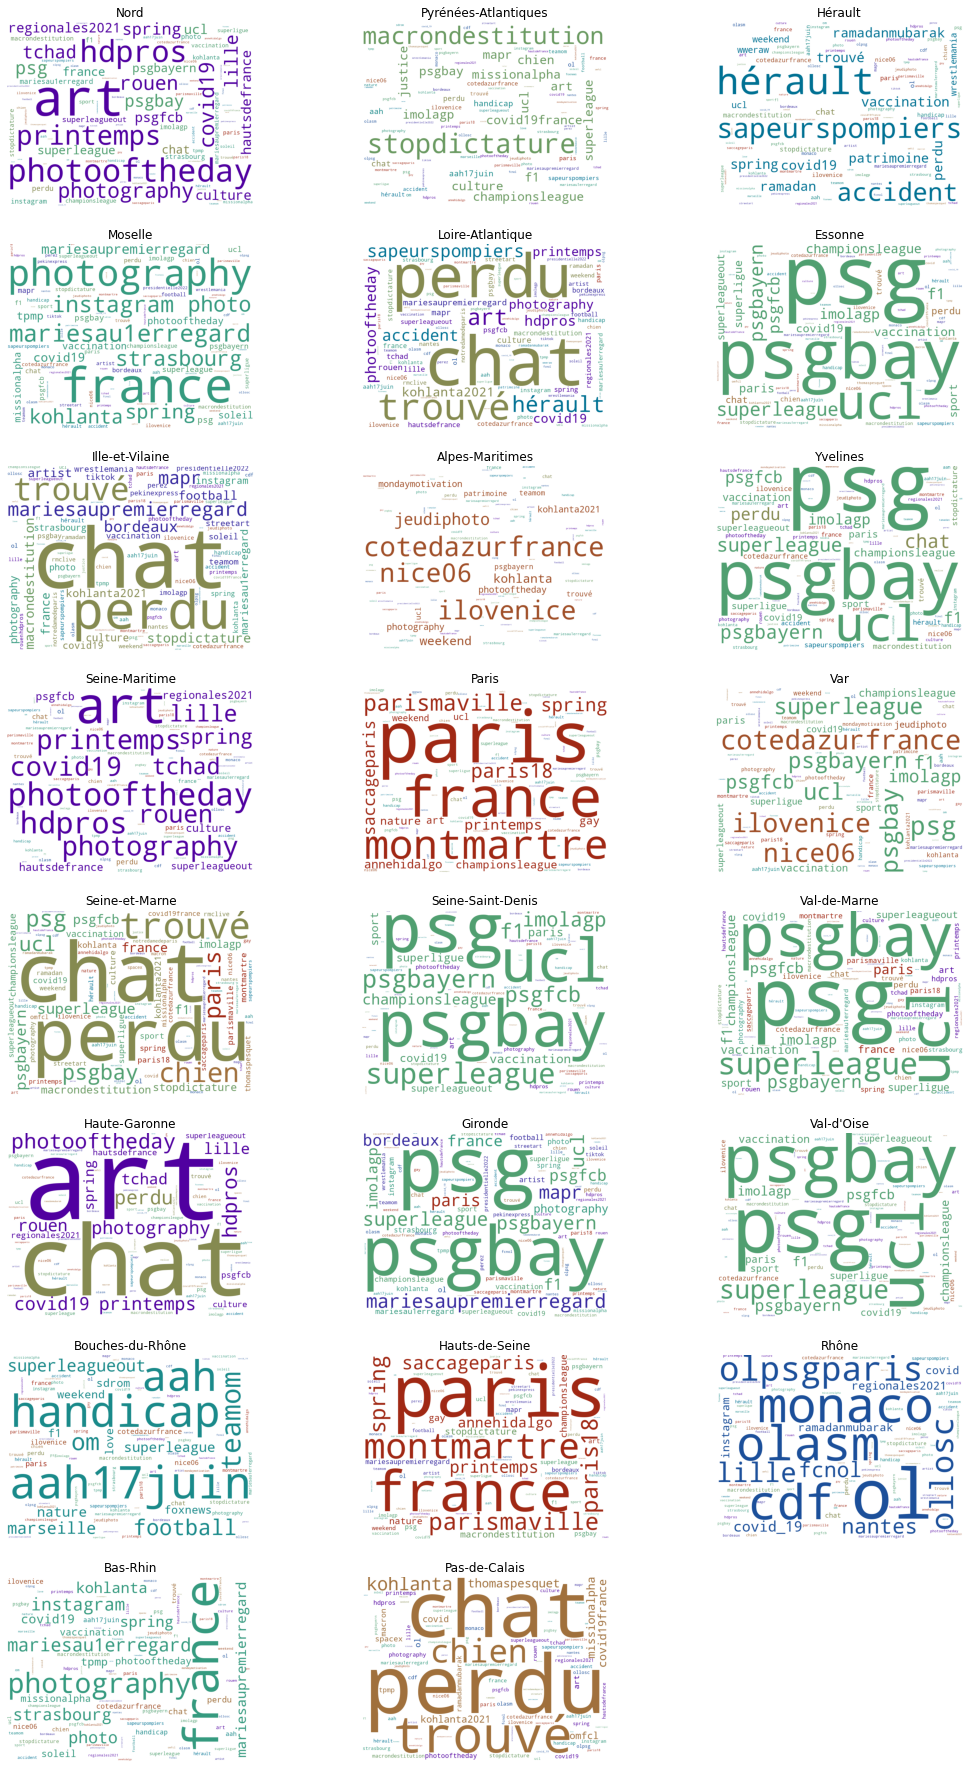

In [84]:
fig = plt.figure(figsize=(18,32))
cmap = cm.get_cmap('rainbow')


dks= lda.local_topics()
for l, dk in enumerate(dks):
    loc = lda.locs[l]
    data = {}
    topic_data = {}
    for (p, t) in dk:
        topic = tks_[t]
        for word in topic:
            if not word in data or data[word] <= topic[word]*p:
                data[word] = topic[word]*p
                topic_data[word]=t
                
    def color(word, **kwargs):
        t = topic_data[word]
        c = cmap(1.0/(len(tks_))*t)[:3]
        c = tuple([int(k*160) for k in c])
        return c
        
    wc = WordCloud(width=800
                   , height=600
                   , max_words=200
                   , color_func=color
                   , background_color='white').generate_from_frequencies(data)
    ax = fig.add_subplot(8, 3, l+1)
    ax.set_title(f"{loc}")
    ax.imshow(wc)
    plt.axis('off')
plt.show()    